In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

## Allen data preprocessing
Get AllenData sessions

In [2]:
basepath = "E:\Allensdk_data\local\ecephys_cache_dir"
manifest_path = os.path.join(basepath, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

sessions = cache.get_session_table()

Select a session randomly

In [3]:
session_id = 799864342
session = cache.get_session_data(session_id)

print(session.structure_acronyms)
print(session.stimulus_names)

['VISam', nan, 'COAa', 'CA1', 'LP', 'DG', 'VISmma', 'VISp', 'ProS', 'SUB', 'CA3', 'CA2', 'VISl', 'VISal', 'LGd', 'VISrl', 'APN', 'POL']


Select 'drifting_gratings' stimuli with contrast 0.8 and temporal_frequency 15.0, but 8 different orientations. 
Each stimuli was presented 15 times for 2 seconds

In [ ]:
stim_table = session.get_stimulus_table('drifting_gratings')
print(stim_table['temporal_frequency'].value_counts())

stim_orientation_table = stim_table[stim_table['temporal_frequency'] == 15.0 ]
print(stim_orientation_table['orientation'].value_counts())
print(stim_orientation_table['stimulus_condition_id'].value_counts())
stim_orientation_table.head()

15.0    120
8.0     120
4.0     120
2.0     120
1.0     120
null     30
Name: temporal_frequency, dtype: int64
270.0    15
45.0     15
315.0    15
90.0     15
135.0    15
180.0    15
225.0    15
0.0      15
Name: orientation, dtype: int64
254    15
252    15
248    15
247    15
277    15
272    15
267    15
256    15
Name: stimulus_condition_id, dtype: int64


,contrast,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3799,0.8,135,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1593.313231,2,drifting_gratings,1595.314911,15,2.00168,247
3800,0.8,45,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1596.315739,2,drifting_gratings,1598.317439,15,2.00170,248
3805,0.8,0,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1611.328291,2,drifting_gratings,1613.329971,15,2.00168,252
3807,0.8,90,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1617.333321,2,drifting_gratings,1619.334971,15,2.00165,254
3809,0.8,315,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1623.338331,2,drifting_gratings,1625.340001,15,2.00167,256


Select units from VISam area as X_a and VISmma area as X_b

In [5]:
VISam_units = session.units[session.units["ecephys_structure_acronym"] == 'VISam']
VISmma_units = session.units[session.units["ecephys_structure_acronym"] == 'VISmma']

In [ ]:
VISam_units

Count spikes in 100ms bins after stimuli onset and spaning a total of 2 seconds

In [6]:
print(stim_orientation_table.duration)
time_step = 0.1
time_bins = np.arange(0, 2 + time_step, time_step)
time_bins

stimulus_presentation_id
3799     2.00168
3800     2.00170
3805     2.00168
3807     2.00165
3809     2.00167
          ...   
49396    2.00167
49409    2.00167
49416    2.00166
49421    2.00169
49426    2.00167
Name: duration, Length: 120, dtype: float64


array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ])

Spike_counts in VISam

In [7]:
VISam_spike_counts = session.presentationwise_spike_counts(
    stimulus_presentation_ids=stim_orientation_table.index.values,  
    bin_edges=time_bins,
    unit_ids=VISam_units.index.values
)
print(VISam_spike_counts.shape)
print(VISam_spike_counts.coords)
VISam_spike_counts['stimulus_presentation_id'].values.shape

(120, 20, 29)
Coordinates:
  * stimulus_presentation_id         (stimulus_presentation_id) int64 3799 ... 49426
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 0.05 ... 1.95
  * unit_id                          (unit_id) int64 951087804 ... 951088476


(120,)

(120, 20, 29)
(2400, 29)


Text(0, 0.5, 'spike counts')

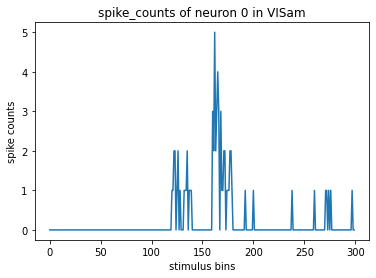

In [8]:
# convert spike_counts structure from stimulus_presentation_id*time_bins* unit_id 
# to stimulus_bins_counts * units, (120, 20, 109) -> (2400, 109)

counts_matrix = VISam_spike_counts.values
print(counts_matrix.shape)
VISam_counts = counts_matrix.reshape(counts_matrix.shape[0]*counts_matrix.shape[1], counts_matrix.shape[2])
print(VISam_counts.shape)

plt.figure()
plt.plot(VISam_counts[:300, 0])
plt.title('spike_counts of neuron 0 in VISam')
plt.xlabel('stimulus bins')
plt.ylabel('spike counts')


Spike_counts in VISmma

In [9]:
VISmma_spike_counts = session.presentationwise_spike_counts(
    stimulus_presentation_ids=stim_orientation_table.index.values,  
    bin_edges=time_bins,
    unit_ids=VISmma_units.index.values
)
print(VISmma_spike_counts.shape)
print(VISmma_spike_counts.coords)
VISmma_spike_counts['stimulus_presentation_id'].values.shape

(120, 20, 44)
Coordinates:
  * stimulus_presentation_id         (stimulus_presentation_id) int64 3799 ... 49426
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 0.05 ... 1.95
  * unit_id                          (unit_id) int64 951091096 ... 951092146


(120,)

(120, 20, 44)
(2400, 44)


Text(0, 0.5, 'spike counts')

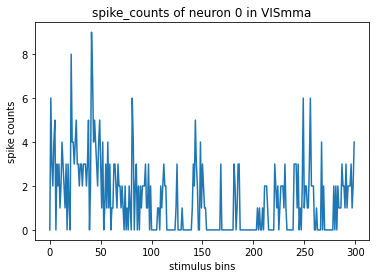

In [10]:
# convert spike_counts structure from stimulus_presentation_id*time_bins* unit_id 
# to stimulus_bins_counts * units, (120, 20, 109) -> (2400, 109)

counts_matrix = VISmma_spike_counts.values
print(counts_matrix.shape)
VISmma_counts = counts_matrix.reshape(counts_matrix.shape[0]*counts_matrix.shape[1], counts_matrix.shape[2])
print(VISmma_counts.shape)

plt.figure()
plt.plot(VISmma_counts[:300, 0])
plt.title('spike_counts of neuron 0 in VISmma')
plt.xlabel('stimulus bins')
plt.ylabel('spike counts')

## CCA between VISam (X_a) and VISmma (X_b)

In [11]:
X_a = VISam_counts
X_b = VISmma_counts

# Standardize data to zero mean and unit variance
X_a = X_a - X_a.mean(axis=0)
X_a = X_a / X_a.std(axis=0)

X_b = X_b - X_b.mean(axis=0)
X_b = X_b / X_b.std(axis=0)

print(X_a.shape)
print(X_b.shape)

(2400, 29)
(2400, 44)


In [12]:
from sklearn.cross_decomposition import CCA

n_components = 10
cca = CCA(n_components)
cca.fit(X_a, X_b)

z_a_sklearn, z_b_sklearn = cca.transform(X_a, X_b) 
print(z_a_sklearn.shape)
print(z_b_sklearn.shape)

(2400, 10)
(2400, 10)


weight get by sklearn.cca

In [13]:
w_a_sklearn = cca.x_rotations_
w_b_sklearn = cca.y_rotations_

print("weight got by sklearn")
print(w_a_sklearn.shape)
print(w_a_sklearn[:5, :5])
print(w_b_sklearn.shape)
print(w_b_sklearn[:5, :5])

weight got by sklearn
(29, 10)
[[ 0.15446314 -0.40686013 -0.33638914 -0.04492249  0.08872337]
 [ 0.08585327 -0.08305584  0.06207071  0.0693492   0.1546403 ]
 [-0.00604659 -0.04849019  0.00528093  0.00926423 -0.08927519]
 [ 0.15493895  0.24499367 -0.14842847 -0.01772624 -0.23251553]
 [ 0.01696952 -0.01556701  0.05195294  0.04707134 -0.03225741]]
(44, 10)
[[-0.42056043  0.74769671 -0.32945403 -0.21047384 -0.19190184]
 [-0.00434449  0.09307483 -0.08183258  0.06649682  0.09404859]
 [ 0.02522731  0.01983522  0.07956942 -0.02389632 -0.07703842]
 [ 0.24344496  0.32277064 -0.09605817 -0.07861089 -0.17214943]
 [ 0.15836319 -0.28632085  0.06559548 -0.16528219 -0.24952958]]


correlation get by sklearn.cca

In [14]:
corr_z_sklearn = np.empty(n_components)

for i in range(n_components):
    corr_z_sklearn[i] = np.corrcoef(z_a_sklearn[:, i], z_b_sklearn[:, i])[0, 1]

print("correlation got by sklearn")
print(corr_z_sklearn)

correlation got by sklearn
[0.70580206 0.68787211 0.47318666 0.45819839 0.41271758 0.37554635
 0.32184232 0.31325953 0.27267573 0.26793366]


plot canonical dimension between different areas

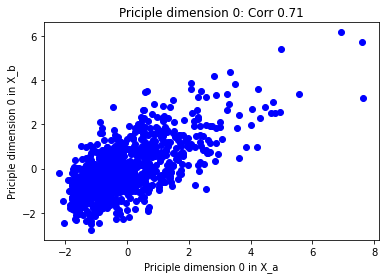

In [15]:
component = 0 # principle components
n_samples = 1000

z_a = z_a_sklearn[:, component]
z_b = z_b_sklearn[:, component]

fig, ax = plt.subplots()
ax1 = ax.scatter(z_a[:n_samples], z_b[:n_samples], c='blue')

ax.set_xlabel(f'Priciple dimension {component} in X_a')
ax.set_ylabel(f'Priciple dimension {component} in X_b')
ax.set_title(f'Priciple dimension {component}: Corr {corr_z_sklearn[component]:.2f}')
plt.show()

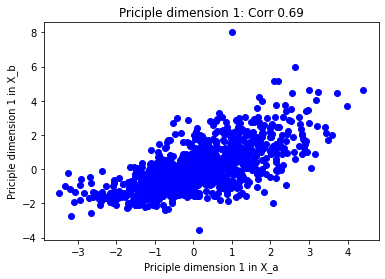

In [16]:
component = 1 # principle components
n_samples = 1000

z_a = z_a_sklearn[:, component]
z_b = z_b_sklearn[:, component]

fig, ax = plt.subplots()
ax1 = ax.scatter(z_a[:n_samples], z_b[:n_samples], c='blue')

ax.set_xlabel(f'Priciple dimension {component} in X_a')
ax.set_ylabel(f'Priciple dimension {component} in X_b')
ax.set_title(f'Priciple dimension {component}: Corr {corr_z_sklearn[component]:.2f}')
plt.show()